<a href="https://colab.research.google.com/github/malteny/cell-classification/blob/main/Cell_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train model which classifies cells as healthy or infected

Based on https://www.tensorflow.org/tutorials/images/classification

Add Kaggle API Credentials and download + unzip data

In [ ]:
! pip3 install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download brsdincer/cell-images-parasitized-or-not
! unzip cell-images-parasitized-or-not.zip

### Import dependencies to convert images into Tensors split in training/test sets

In [9]:
import numpy as np
import pathlib
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [10]:
data_dir = pathlib.Path('/content/cell_images')
total_count = len(list(data_dir.glob('*/*/*.png')))
print(total_count)
test_count = len(list(data_dir.glob('test/*/*.png')))
print(test_count)

27558
2600


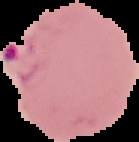

In [11]:
data_dir = pathlib.Path('/content/cell_images')
test_parasitized = list(data_dir.glob('test/parasitized/*.png'))
img = PIL.Image.open(str(test_parasitized[0]))

img # Show image

### Load data using keras utility

In [12]:
(img_height, img_width) = img.size
batch_size = 64
data_dir = pathlib.Path('/content/cell_images/train')

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 24958 files belonging to 2 classes.
Using 19967 files for training.
Found 24958 files belonging to 2 classes.
Using 4991 files for validation.


### Visualize the data

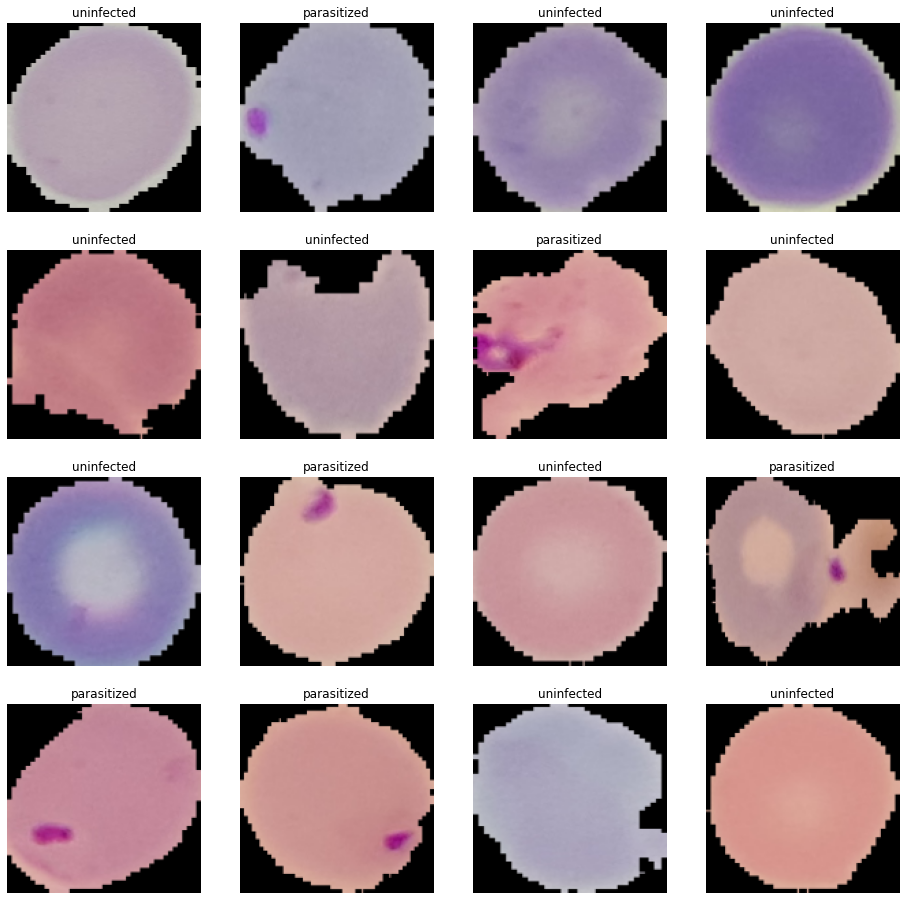

In [13]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(16,16))
first_64 = train_ds.take(1)

for images, labels in first_64:
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# Print shape of the image_batch tensor and labels_batch tensor.

(64, 139, 142, 3)
(64,)


Normalization layer which will be included in final model

In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

Configure dataset for performance by keeping images in memory after first epoch

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Build and fit model

In [17]:
num_classes = 2

model = tf.keras.Sequential([
  normalization_layer,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes),
  tf.keras.layers.Softmax()
])

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

Create custom logging callback

In [18]:
# Purpose: Create callback which writes accuracy + loss after each
# trained batch.

# Modified tf.keras.callbacks.CSVLogger code found at:
# https://github.com/keras-team/keras/blob/v2.6.0/keras/callbacks.py#L2705-L2784

import csv
import collections
from keras.utils.io_utils import path_to_string

class CSV_trainlogger(tf.keras.callbacks.Callback):

  def __init__(self, filename, separator=',', append=False):
    self.sep = separator
    self.filename = path_to_string(filename)
    self.append = append
    self.writer = None
    self.keys = None
    self.append_header = True
    super(CSV_trainlogger, self).__init__()

  def on_train_batch_begin(self, batch, logs=None):
    if self.append:
      if tf.io.gfile.exists(self.filename):
        with tf.io.gfile.GFile(self.filename, 'r') as f:
          self.append_header = not bool(len(f.readline()))
      mode = 'a'
    else:
      mode = 'w'
    self.csv_file = tf.io.gfile.GFile(self.filename, mode)

  def on_train_batch_end(self, train, logs=None):
    logs = logs or {}

    def handle_value(k):
      is_zero_dim_ndarray = isinstance(k, np.ndarray) and k.ndim == 0
      if isinstance(k, str):
        return k
      elif isinstance(k, collections.abc.Iterable) and not is_zero_dim_ndarray:
        return '"[%s]"' % (', '.join(map(str, k)))
      else:
        return k

    if self.keys is None:
      self.keys = sorted(logs.keys())

    if self.model.stop_training:
      # We set NA so that csv parsers do not fail for this last epoch.
      logs = dict((k, logs[k]) if k in logs else (k, 'NA') for k in self.keys)

    if not self.writer:

      class CustomDialect(csv.excel):
        delimiter = self.sep

      fieldnames = ['train'] + self.keys

      self.writer = csv.DictWriter(
          self.csv_file,
          fieldnames=fieldnames,
          dialect=CustomDialect)
      if self.append_header:
        self.writer.writeheader()

    row_dict = collections.OrderedDict({'train': train})
    row_dict.update((key, handle_value(logs[key])) for key in self.keys)
    self.writer.writerow(row_dict)
    self.csv_file.flush()

In [20]:
batch_logs = CSV_trainlogger(
    'batch_logs.log',
    separator=',',
    append=False
)

epoch_logs = tf.keras.callbacks.CSVLogger(
    'epoch_logs.log',
    separator=',',
    append=False
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/best_model',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[batch_logs, epoch_logs, checkpoint]
)

model.save('trained1')

Epoch 1/5
312/312 [==============================] - 484s 2s/step - loss: 0.4508 - accuracy: 0.7611 - val_loss: 0.2066 - val_accuracy: 0.9301
INFO:tensorflow:Assets written to: /tmp/best_model/assets
Epoch 2/5
312/312 [==============================] - 456s 1s/step - loss: 0.1758 - accuracy: 0.9421 - val_loss: 0.1752 - val_accuracy: 0.9467
INFO:tensorflow:Assets written to: /tmp/best_model/assets
Epoch 3/5
312/312 [==============================] - 469s 2s/step - loss: 0.1452 - accuracy: 0.9545 - val_loss: 0.1368 - val_accuracy: 0.9569
INFO:tensorflow:Assets written to: /tmp/best_model/assets
Epoch 4/5
312/312 [==============================] - 467s 1s/step - loss: 0.1321 - accuracy: 0.9579 - val_loss: 0.1389 - val_accuracy: 0.9545
Epoch 5/5
312/312 [==============================] - 464s 1s/step - loss: 0.1203 - accuracy: 0.9601 - val_loss: 0.1438 - val_accuracy: 0.9513
INFO:tensorflow:Assets written to: trained1/assets


### Graph test-/validation loss and accuracy

<function matplotlib.pyplot.show>

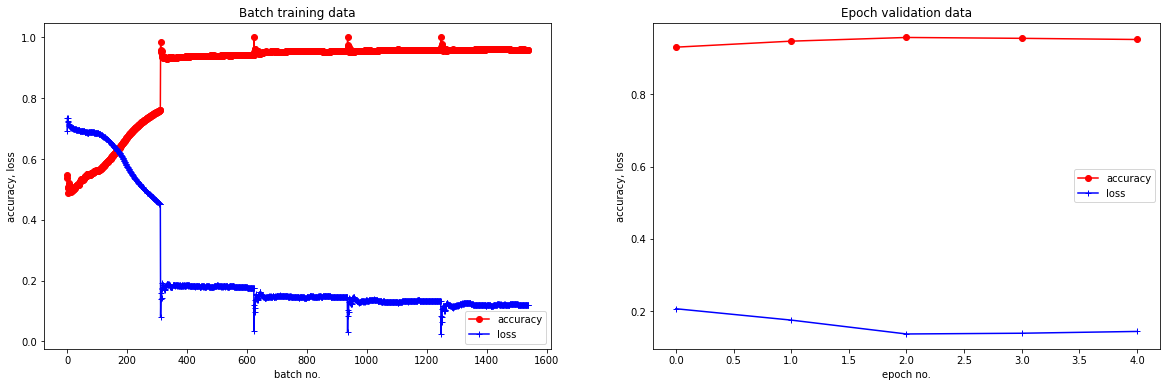

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

batch_data = pd.read_csv('/content/batch_logs.log')
epoch_data = pd.read_csv('/content/epoch_logs.log')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(6)
ax1.set_title('Batch training data')
ax1.plot(batch_data.index, batch_data['accuracy'], 'or-', label='accuracy')
ax1.plot(batch_data.index, batch_data['loss'], '+b-', label='loss')
ax1.set_xlabel('batch no.')
ax1.set_ylabel('accuracy, loss')

ax2.set_title('Epoch validation data')
ax2.plot(epoch_data.index, epoch_data['val_accuracy'], 'or-', label='accuracy')
ax2.plot(epoch_data.index, epoch_data['val_loss'], '+b-', label='loss')
ax2.set_xlabel('epoch no.')
ax2.set_ylabel('accuracy, loss')

ax1.legend(loc='lower right')
ax2.legend()

plt.show


### Test Model with test dataset

In [28]:
data_dir = pathlib.Path('cell_images/test')

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

test_history = model.evaluate(
    test_ds
)

Found 2600 files belonging to 2 classes.
41/41 [==============================] - 20s 460ms/step - loss: 0.1638 - accuracy: 0.9481


### Visualize testing results

[0.1637895107269287, 0.9480769038200378]


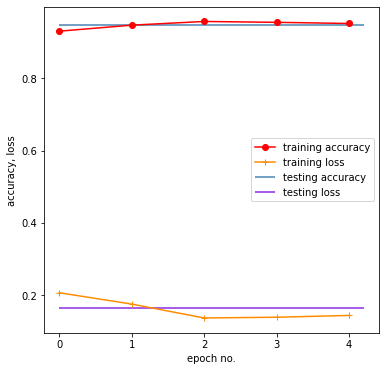

In [89]:
print(test_history)

fig, ax = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(6)

ax.plot(epoch_data.index, epoch_data['val_accuracy'], 'o-', color='red', label='training accuracy')
ax.plot(epoch_data.index, epoch_data['val_loss'], '+-', color='darkorange', label='training loss')
ax.set_xlabel('epoch no.')
ax.set_ylabel('accuracy, loss')

xlim = ax.get_xlim()

ax.hlines(test_history[1], 0, xlim[1], colors='steelblue', label='testing accuracy')
ax.hlines(test_history[0], 0, xlim[1], colors='blueviolet', label='testing loss')

ax.legend(loc='center right')